###Housing prices
Predicting housing prices in various areas, based on some features.

##Preprocessing and cleansing

In [5]:
import pandas as pd
data = pd.read_csv("housing.csv", sep=",",decimal=".")
print(data.shape)
print(data.columns.values)

(505, 6)
['crime_rate' 'avg_number_of_rooms' 'distance_to_employment_centers'
 'property_tax_rate' 'pupil_teacher_ratio' 'house_value']


This is quite a small dataset.

In [11]:
data.describe()

,crime_rate,avg_number_of_rooms,distance_to_employment_centers,property_tax_rate,pupil_teacher_ratio,house_value
count,505.000000,505.000000,505.000000,505.000000,505.000000,505.000000
mean,3.620667,6.284059,3.794459,408.459406,18.461782,22.529901
std,8.608572,0.703195,2.107757,168.629992,2.162520,9.205991
min,0.009060,3.561000,1.129600,187.000000,12.600000,5.000000
25%,0.082210,5.885000,2.100000,279.000000,17.400000,17.000000
50%,0.259150,6.208000,3.199200,330.000000,19.100000,21.200000
75%,3.678220,6.625000,5.211900,666.000000,20.200000,25.000000
max,88.976200,8.780000,12.126500,711.000000,22.000000,50.000000


In [12]:
print("Crime Max/Min: ", data.crime_rate.max()/data.crime_rate.min())

Max/Min:  9820.772626931568


Wow! The crime rates vary by a factor of 10,000! What is the unit, anyway? Hardly 90 crimes per capita = for each inhabitant? In what period? If the period is, for example, per month, there could be a lot of variance due to the short period. 

Otherwise, there don't seem to be any absurd values.
Should I dismiss the high crime values as outliers? 
OK, this is just a toy example. I'll just leave all data as it is, at least for now.

Then, some intuitions and reasoning about the data relationships. 
One would expect the median house price to be higher in areas with a low crime rate, high average number of rooms (i.e. big, posh villas in the area), short distance to employment center, low property tax rate (think Kauniainen), and low pupil/teacher ratio.
Let's run some pairwise plotting to get a feeling of the data - while bearing in mind that simple eyeball analytics can be misleading, as we have several independent variables, and know nothing about their relationships, collinearity etc.
Visualisation code credits to www.ritchieng.com 

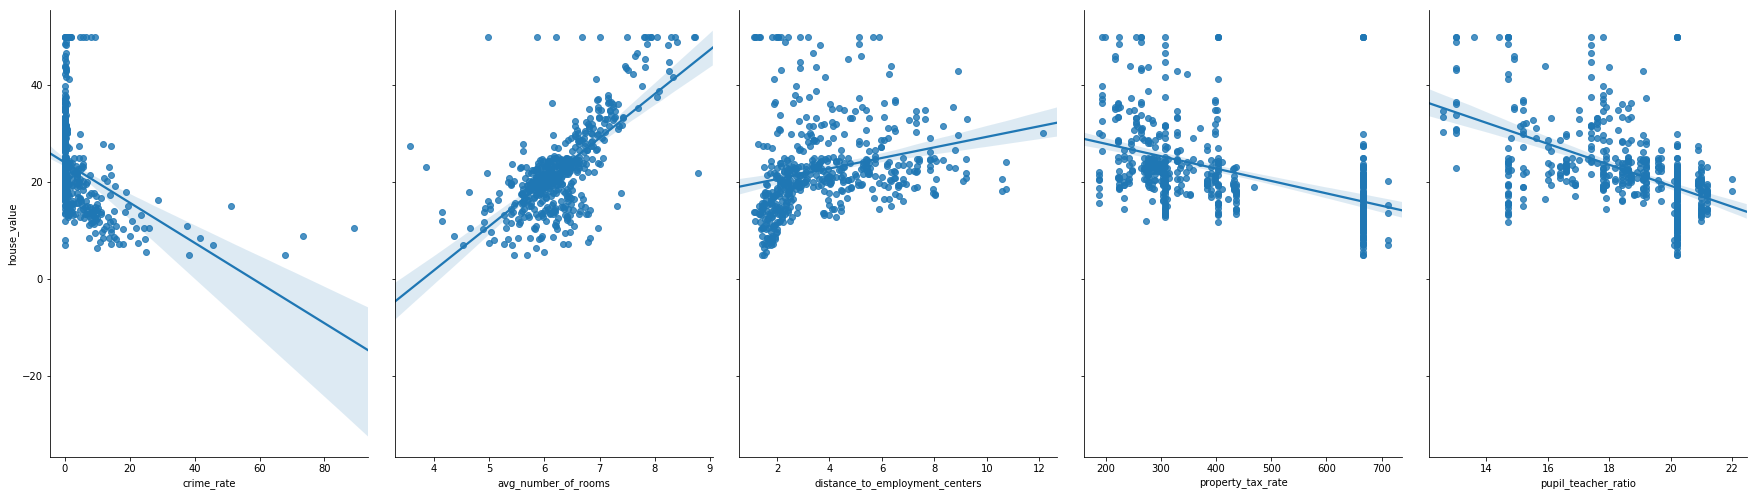

In [7]:
import seaborn as sns
sns.pairplot(data, x_vars=['crime_rate', 'avg_number_of_rooms', 
                           'distance_to_employment_centers', 'property_tax_rate', 'pupil_teacher_ratio'],
            y_vars='house_value', size=7, aspect=0.7, kind='reg')

Based on the plot, my intuition about crime rate and distance to employment centers seems wrong - but let's not jump to conclusions. 
The crime rate data has some high leverage points, which probably distort the picture. The line is an ordinary least squares fit, which probably fits poorly. Crime distribution is probably gamma, certainly not normal.
Distance to employment centers - well, big villas need lots of space. The folks are ready to ride their Porsches for the extra mile.

Again, there are some data points that look suspicious in these plots. For example, in the second plot, the top row of house values runs horizontally = zero correlation with number of rooms. But, relations with other variables could account for that, so I'm not doing any cleansing based on this.
Can't judge whether the relationships are linear or not, and if there are cross relationships, so I'll just try on a couple of models and see which seem to work best.

##Models
A 1st degree multivariate linear model, ordinary least squares 

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
lm1 = LinearRegression(fit_intercept=True, normalize=True, copy_X=True)
feature_columns = data.columns.values[0:-1]
X = data[feature_columns]
y = data.house_value
lm1.fit(X,y)
print(feature_columns)
print(lm1.coef_)
print("R2 score: ", lm1.score(X,y))
print("MSE for OLS 1: ", sqrt(mean_squared_error(y, lm1.predict(X))))
y_mean = pd.Series(data.shape[0]*[y.mean()])
print("MSE guessing y = mean of y: ", sqrt(mean_squared_error(y, y_mean)))

['crime_rate' 'avg_number_of_rooms' 'distance_to_employment_centers'
 'property_tax_rate' 'pupil_teacher_ratio']
[-0.14050266  7.26710714 -0.20805789 -0.00863775 -0.90056935]
R2 score:  0.6067850198780185
MSE for OLS 1:  5.767069217970965
MSE guessing y = mean of y 9.19687188480108


Above, I'm doing something I should never ever do - evaluate the model performance based on training data. However, I'm just using it to get an idea. If the R2 value is that poor even with in sample data, it sure won't do well on out of sample data.
So, as the plots suggest, a simple linear model doesn't perform well. Let's try something else.
The MSE can serve as baseline.

In [ ]:
From this scikit-learn cheat sheet, seems Lasso could be a good guess

![selecting methods](scikit_cheat.PNG)

In [34]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LassoCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
cvm = LassoCV(n_alphas=10, normalize=True, cv=4, random_state=99)
cvm.fit(X_train, y_train)
y_predicted = cvm.predict(X_test)
print("MSE for cross-validated Lasso (1st degree linear): ", sqrt(mean_squared_error(y_test, y_predicted)))

MSE for cross-validated Lasso (1st degree linear):  6.367785589982808


At first glance, looks worse than OLS. But that's to be expected! 
Now we are testing out of sample, and still a 1st degree linear model. Trying polynomial features, including cross products.
Neat code adapted from 
https://towardsdatascience.com/machine-learning-with-python-easy-and-robust-method-to-fit-nonlinear-data-19e8a1ddbd49

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
degrees = range(1,6)
rmse = []
r2 = []
for degree in degrees:
    cvpm = make_pipeline(
        PolynomialFeatures(degree, interaction_only=False),
        LassoCV(n_alphas=20, normalize=True, cv=4, random_state=99))
    cvpm.fit(X_train, y_train)
    y_predicted = cvpm.predict(X_test)
    rmse.append(sqrt(mean_squared_error(y_test, y_predicted)))
    r2.append(cvpm.score(X_test, y_test))

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\pihlaart1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\

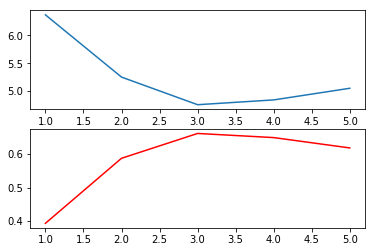

Best root MSE:  4.755465392511242
Best R2:  0.6616755629683715


In [45]:
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(211)
plt.plot(degrees,rmse)
plt.subplot(212)
plt.plot(degrees, r2, 'r')
plt.show()
print("Best root MSE: ", min(rmse))
print("Best R2: ", max(r2))

Seems a 3rd degree polynomial with cross terms fits best. Lots of warnings about non-convergence. Should probably try tweak the hyperparameters. Can also be due to the small dataset. I'll leave this here and do some other stuff for a change.
## Next steps
To improve the model
- try nonparametric, K-neighbours regression
- bin output values and try random forest